---
title: 多个蓝牙加速度计的实时同步实验
series: ml
create_date: 2020-02-21 15:36:00
update_date: 2020-02-21 15:36:00
type: post
---

- - -

${toc}

- - -

## Setup and run streams

Import packages

In [0]:
import arus
import pandas as pd
import numpy as np
import logging
import time
arus.dev.set_default_logging()

Scan nearby devices

In [0]:
# Get device addr
scanner = arus.plugins.metawear.MetaWearScanner()
addrs = scanner.get_nearby_devices(max_devices=3)
addrs = addrs[0:3]

[INFO]2020-02-05 19:31:41,626 <P13484-MainThread> Scanning metawear devices nearby...
[INFO]2020-02-05 19:31:42,631 <P13484-MainThread> Scanning metawear devices nearby...
[INFO]2020-02-05 19:31:43,632 <P13484-MainThread> Scanning metawear devices nearby...


Setup streams

In [0]:
# prepare streams
streams = []
ref_st = pd.Timestamp.now()
for addr in addrs:
    generator = arus.plugins.metawear.MetaWearAccelDataGenerator(
        addr, sr=50, grange=8, buffer_size=100)
    segmentor = arus.segmentor.SlidingWindowSegmentor(
        window_size=2)
    stream = arus.Stream(generator, segmentor,
                         name='metawear-stream-{}'.format(addr))
    streams.append(stream)

Start streams

In [0]:
# start stream
results = {}
for stream in streams:
    stream.start(start_time=ref_st)
    results[stream._name] = []


In [0]:
done = [False] * len(streams)
while True:
    for stream in streams:
        for data, st, et, _, _, name in stream.get_iterator():
            data['ST'] = st
            data['ET'] = et
            i = streams.index(stream)
            logging.info('data from: {}, {}'.format(
                name, i))
            results[name].append(data)
            if len(results[name]) == 20:
                done[i] = True
            break
    if np.all(done):
        break

for stream in streams:
    stream.stop()

combined = []
for name, result in results.items():
    name = name.replace(':', '')
    result = pd.concat(result, sort=False)
    combined.append(result)

combined = pd.concat(combined, sort=False)



[INFO]2020-02-05 19:31:57,744 <P13484-metawear-stream-D5:D2:01:2B:E7:6D-loading> New metawear connected: MetaWearClient, D5:D2:01:2B:E7:6D: {'model': '5', 'hardware': '0.3', 'manufacturer': 'MbientLab Inc', 'serial': '031371', 'firmware': '1.5.0'}
[INFO]2020-02-05 19:31:57,773 <P13484-metawear-stream-D5:D2:01:2B:E7:6D-loading> starting accelerometer module...
[INFO]2020-02-05 19:31:57,774 <P13484-metawear-stream-D5:D2:01:2B:E7:6D-loading> Waiting for accelerometer callback to start...
[INFO]2020-02-05 19:31:57,782 <P13484-Dummy-8> Accelerometer callback starts running...
[INFO]2020-02-05 19:31:57,790 <P13484-metawear-stream-D5:D2:01:2B:E7:6D-loading> Accelerometer callback started successfully.
[INFO]2020-02-05 19:31:57,833 <P13484-MainThread> data from: metawear-stream-D5:D2:01:2B:E7:6D, 0
[INFO]2020-02-05 19:31:57,905 <P13484-MainThread> data from: metawear-stream-E6:F8:37:54:03:87, 1
[INFO]2020-02-05 19:31:57,977 <P13484-MainThread> data from: metawear-stream-FF:EE:B8:99:0C:64, 2
[I

 ## Analyze results
 ### Check the first sample timestamp
 1. **referenced start time**: The start time used as a reference to segment the incoming data. This value is set before setting up and start the streams.
 2. **first sample timestamp**: The timestamp of the first sample received from each device. This timestamp has been synced with the computer clock when receiving the data.
 3. **first sample device timestamp**: The timestamp of the first sample received from each device. This timestamp has not been synced with the computer clock when receiving the data.

In [0]:
first_sample = combined.groupby(by=['MAC_ADDRESS']).apply(
    lambda df: df[['HEADER_TIME_STAMP', 'NO_FIX']].iloc[0, :])
first_sample = first_sample.rename(
    columns={'HEADER_TIME_STAMP': 'first sample timestamp', 'NO_FIX': 'first sample device timestamp'})
first_sample = first_sample.sort_values(by=['first sample timestamp'])
first_sample['referenced start time'] = ref_st
first_sample['diff_ref (s)'] = arus.Moment.get_durations(
    first_sample['referenced start time'], first_sample['first sample timestamp'])
first_sample['diff_device (s)'] = arus.Moment.get_durations(
    first_sample['first sample device timestamp'],
    first_sample['first sample timestamp'])
first_sample.transpose()

MAC_ADDRESS,FF:EE:B8:99:0C:64,E6:F8:37:54:03:87,D5:D2:01:2B:E7:6D
0,,,
first sample timestamp,2020-02-05 19:31:54.511123,2020-02-05 19:31:54.950348,2020-02-05 19:31:57.779814
first sample device timestamp,2020-02-05 19:31:54.511000,2020-02-05 19:31:54.950000,2020-02-05 19:31:57.780000
referenced start time,2020-02-05 19:31:51.878749,2020-02-05 19:31:51.878749,2020-02-05 19:31:51.878749
diff_ref (s),2.63237,3.0716,5.90107
diff_device (s),0.000123,0.000348,-0.000186


 ### Check number of samples in each segments

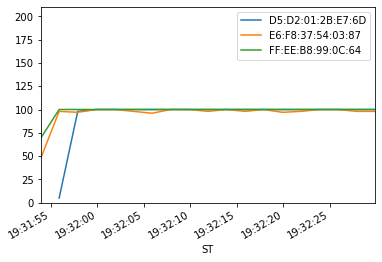

In [0]:
count_segment = combined.groupby(
    by=['MAC_ADDRESS', 'ST']).size().to_frame(name='# of samples').reset_index(drop=False)
count_segment = count_segment.pivot(
    columns='MAC_ADDRESS', index='ST', values=['# of samples'])
count_segment.columns = sorted(addrs)
count_segment.reset_index(drop=False, inplace=True)
count_segment.plot(x='ST', kind='line', ylim=(0, 210))